# converted to mongodb

In [4]:
from pymongo import MongoClient
import matplotlib.pyplot as plt

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  
collection = db['reports']  

# Plot gender distribution per year (1990-2023)

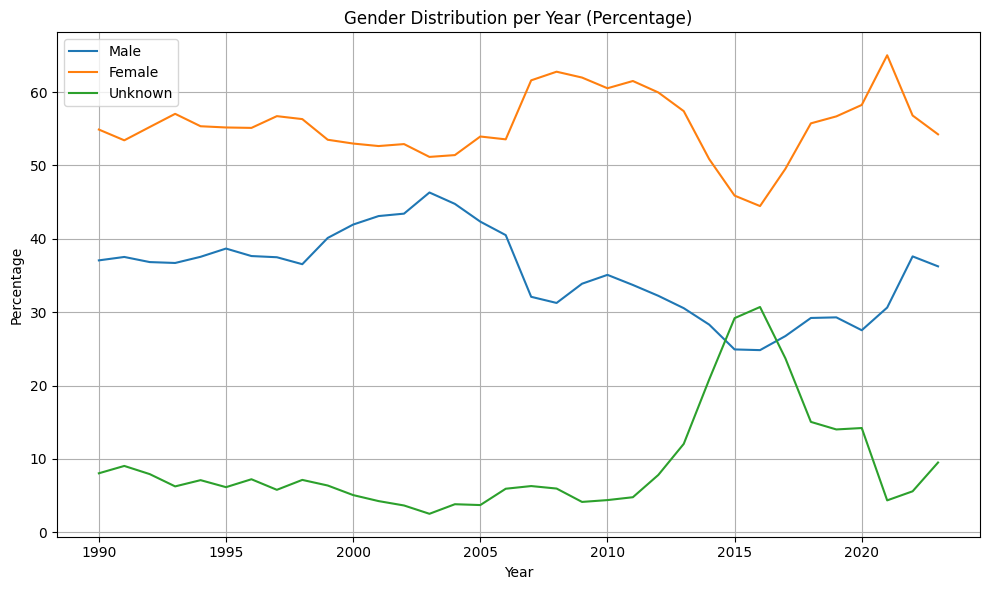

In [5]:
pipeline = [
    {
        "$project": {
            "year": {"$year": "$RECVDATE"},
            "sex": "$SEX"
        }
    },
    {
        "$group": {
            "_id": {"year": "$year", "sex": "$sex"},
            "count": {"$sum": 1}
        }
    },
    {
        "$group": {
            "_id": "$_id.year",
            "gender_counts": {
                "$push": {"sex": "$_id.sex", "count": "$count"}
            },
            "total_count": {"$sum": "$count"}
        }
    },
    {
        "$sort": {"_id": 1}
    }
]

# Execute the aggregation pipeline
gender_distribution_per_year = list(collection.aggregate(pipeline))

# Process the results into a format suitable for plotting
years = []
male_percentages = []
female_percentages = []
unknown_percentages = []

for entry in gender_distribution_per_year:
    year = entry['_id']
    years.append(year)
    total_count = entry['total_count']
    gender_counts = {gender_count['sex']: gender_count['count'] for gender_count in entry['gender_counts']}
    male_percentages.append((gender_counts.get('M', 0) / total_count) * 100)
    female_percentages.append((gender_counts.get('F', 0) / total_count) * 100)
    unknown_percentages.append((gender_counts.get('U', 0) / total_count) * 100)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, male_percentages, label='Male')
plt.plot(years, female_percentages, label='Female')
plt.plot(years, unknown_percentages, label='Unknown')

# Formatting the plot
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Gender Distribution per Year (Percentage)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

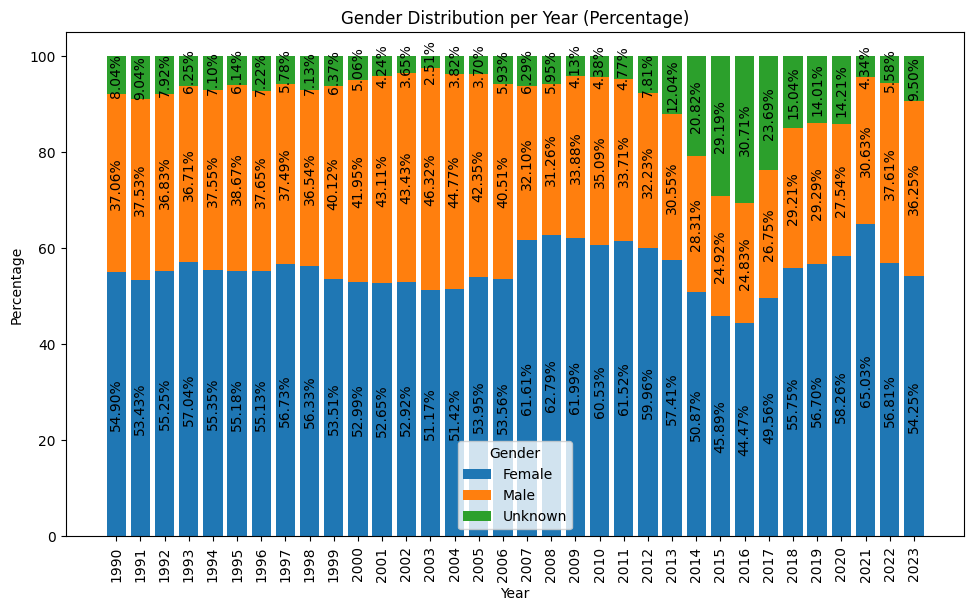

In [30]:
# Define the aggregation pipeline
pipeline = [
    {
        "$project": {
            "year": {"$year": "$RECVDATE"},
            "sex": "$SEX"
        }
    },
    {
        "$group": {
            "_id": {"year": "$year", "sex": "$sex"},
            "count": {"$sum": 1}
        }
    },
    {
        "$group": {
            "_id": "$_id.year",
            "gender_counts": {
                "$push": {"sex": "$_id.sex", "count": "$count"}
            },
            "total_count": {"$sum": "$count"}
        }
    },
    {
        "$sort": {"_id": 1}
    }
]

# Execute the aggregation pipeline
gender_distribution_per_year = list(collection.aggregate(pipeline))

# Process the results into a format suitable for plotting
years = []
male_percentages = []
female_percentages = []
unknown_percentages = []

for entry in gender_distribution_per_year:
    year = entry['_id']
    years.append(year)
    total_count = entry['total_count']
    gender_counts = {gender_count['sex']: gender_count['count'] for gender_count in entry['gender_counts']}
    male_percentages.append((gender_counts.get('M', 0) / total_count) * 100)
    female_percentages.append((gender_counts.get('F', 0) / total_count) * 100)
    unknown_percentages.append((gender_counts.get('U', 0) / total_count) * 100)

# Plotting
plt.figure(figsize=(10, 6))
bars2 = plt.bar(years, female_percentages, label='Female')
bars1 = plt.bar(years, male_percentages, bottom=female_percentages, label='Male')  # Reversed order
bars3 = plt.bar(years, unknown_percentages, bottom=[m + f for m, f in zip(male_percentages, female_percentages)], label='Unknown')

# Add percentage labels inside each bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        percentage = f'{height:.2f}%'
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, percentage,
                 ha='center', va='center', color='black', rotation=90)

# Formatting the plot
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Gender Distribution per Year (Percentage)')
plt.legend(title='Gender', loc='lower center')
plt.tight_layout()
plt.xticks(years, rotation=90)
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Gender_Distribution/Gender_Distribution_Per_Year.png')
plt.show()


# Gender distribution for Covid-19 vaccinations

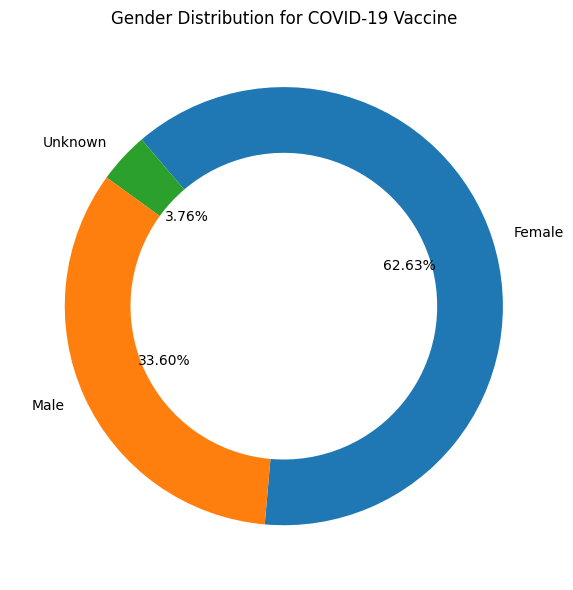

In [18]:
# Define the aggregation pipeline for non-COVID-19 vaccines with unwinding vax_data
pipeline_covid_unwind_all_years = [
    {
        "$unwind": "$vax_data"  # Unwind the vax_data array
    },
    {
        "$match": {"vax_data.VAX_TYPE": {"$regex": "COVID", "$options": "i"}}
    },
    {
        "$group": {
            "_id": {
                "$switch": {
                    "branches": [
                        {"case": {"$eq": ["$SEX", "M"]}, "then": "Male"},
                        {"case": {"$eq": ["$SEX", "F"]}, "then": "Female"},
                    ],
                    "default": "Unknown"
                }
            },
            "count": {"$sum": 1}
        }
    }
]

# Execute the aggregation pipeline for non-COVID-19 vaccines with unwinding vax_data
gender_distribution_covid_unwind_all_years = list(collection.aggregate(pipeline_covid_unwind_all_years))

# Process the results into a format suitable for plotting
total_count_covid_unwind_all_years = sum(entry['count'] for entry in gender_distribution_covid_unwind_all_years)
gender_counts_covid_unwind_all_years = {entry['_id']: entry['count'] / total_count_covid_unwind_all_years * 100 for entry in gender_distribution_covid_unwind_all_years}

# Plotting for non-COVID-19 vaccines with unwinding vax_data
plt.figure(figsize=(10, 6))

# Custom colors for Female, Male, and Unknown categories
colors = ['tab:blue', 'tab:green', 'tab:orange']

# Plotting the pie chart with custom colors
plt.pie(gender_counts_covid_unwind_all_years.values(), labels=gender_counts_covid_unwind_all_years.keys(), autopct='%1.2f%%', startangle=265, wedgeprops={'width': 0.3}, colors=colors)

# Formatting the plot
plt.title('Gender Distribution for COVID-19 Vaccine')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Gender_Distribution/Gender_Distribution_Covid_Vaccinations.png')
plt.show()

# Gender distribution for all vaccinations besides Covid-19

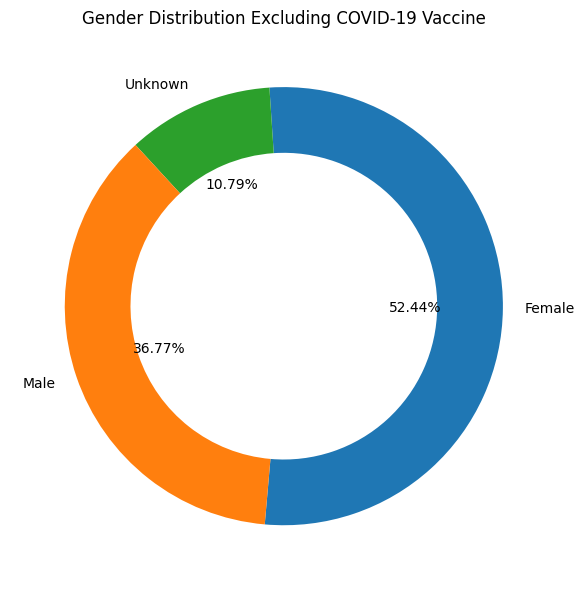

In [29]:
# Define the aggregation pipeline for non-COVID-19 vaccines with unwinding vax_data
pipeline_non_covid_unwind_all_years = [
    {
        "$unwind": "$vax_data"  # Unwind the vax_data array
    },
    {
        "$match": {"vax_data.VAX_TYPE": {"$not": {"$regex": "COVID", "$options": "i"}}}
    },
    {
        "$group": {
            "_id": {
                "$switch": {
                    "branches": [
                        {"case": {"$eq": ["$SEX", "M"]}, "then": "Male"},
                        {"case": {"$eq": ["$SEX", "F"]}, "then": "Female"},
                    ],
                    "default": "Unknown"
                }
            },
            "count": {"$sum": 1}
        }
    }
]

# Execute the aggregation pipeline for non-COVID-19 vaccines with unwinding vax_data
gender_distribution_non_covid_unwind_all_years = list(collection.aggregate(pipeline_non_covid_unwind_all_years))

# Process the results into a format suitable for plotting
total_count_non_covid_unwind_all_years = sum(entry['count'] for entry in gender_distribution_non_covid_unwind_all_years)
gender_counts_non_covid_unwind_all_years = {entry['_id']: entry['count'] / total_count_non_covid_unwind_all_years * 100 for entry in gender_distribution_non_covid_unwind_all_years}

# Plotting for non-COVID-19 vaccines with unwinding vax_data
plt.figure(figsize=(10, 6))

# Custom colors for Female, Male, and Unknown categories
colors = ['tab:blue', 'tab:green', 'tab:orange']

# Plotting the pie chart with custom colors
plt.pie(gender_counts_non_covid_unwind_all_years.values(), labels=gender_counts_non_covid_unwind_all_years.keys(), autopct='%1.2f%%', startangle=265, wedgeprops={'width': 0.3}, colors=colors)

# Formatting the plot
plt.title('Gender Distribution Excluding COVID-19 Vaccine')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Gender_Distribution/Non_COVID_Gender_Distribution_Donut.png')
plt.show()